# Fine-tune A Language Model

- We'll be finetuning an LLM on a specific target task, such as classifying text.
- Using:
  - Hugging Face Transformers
  - PyTorch

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning,transformers --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy       : 1.26.4
pandas      : 2.2.1
polars      : 0.20.18
torch       : 2.2.2
lightning   : 2.2.1
transformers: 4.39.3

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from utils import go_up_from_current_directory

go_up_from_current_directory(go_up=1)
from data_prep.data_prep import DataCleaner

/Users/neidu/Desktop/Projects/Personal/My_Projects/NLP-Tutorial/notebook


### Load Data

In [4]:
fp: str = "./models/spend_df.parquet"

df: pl.DataFrame = pl.read_parquet(fp).drop(
    ["index", "date", "type", "amount", "balance", "tags"]
)
print(f"Shape of data: {df.shape} \n")

df.head()

Shape of data: (1608255, 4) 



customer_id,nuban,description,label
str,i64,str,str
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""
"""33950""",1,"""Quantum USSD""","""noSpend"""


In [5]:
df.group_by("label").agg(pl.len()).to_pandas()

,label,len
0,loan,41454
1,savingsAndInvestments,4059
2,noSpend,1529430
3,bills,33312


In [6]:
TEXT_COLUMN: str = "description"

df = DataCleaner(data=df, text_column=TEXT_COLUMN).prepare_data()
df.to_pandas().head()

,customer_id,nuban,description,label,cleaned_text
0,33950,1,Quantum USSD,noSpend,quantum ussd
1,33950,1,Quantum USSD,noSpend,quantum ussd
2,33950,1,Quantum USSD,noSpend,quantum ussd
3,33950,1,Quantum USSD,noSpend,quantum ussd
4,33950,1,Quantum USSD,noSpend,quantum ussd


In [7]:
TEXT_COLUMN: str = "cleaned_text"
df = df.with_columns(desc_length=pl.col(TEXT_COLUMN).str.len_chars())

df.to_pandas().head()

,customer_id,nuban,description,label,cleaned_text,desc_length
0,33950,1,Quantum USSD,noSpend,quantum ussd,12
1,33950,1,Quantum USSD,noSpend,quantum ussd,12
2,33950,1,Quantum USSD,noSpend,quantum ussd,12
3,33950,1,Quantum USSD,noSpend,quantum ussd,12
4,33950,1,Quantum USSD,noSpend,quantum ussd,12


In [8]:
df.describe()

statistic,customer_id,nuban,description,label,cleaned_text,desc_length
str,str,f64,str,str,str,f64
"""count""","""1608255""",1.608255e6,"""1608255""","""1608255""","""1608255""",1.608255e6
"""null_count""","""0""",0.0,"""0""","""0""","""0""",0.0
"""mean""",null,1.0,null,null,null,32.907305
"""std""",null,0.0,null,null,null,16.400539
"""min""","""33790""",1.0,""" WASIU ABAS…","""bills""","""""",0.0
"""25%""",null,1.0,null,null,null,18.0
"""50%""",null,1.0,null,null,null,34.0
"""75%""",null,1.0,null,null,null,45.0
"""max""","""36192""",1.0,"""yunusa Badama…","""savingsAndInve…","""zuriyat ladidi…",136.0


In [9]:
text_length: int = 20

df = df.filter(pl.col("desc_length").ge(text_length))
df.describe()

statistic,customer_id,nuban,description,label,cleaned_text,desc_length
str,str,f64,str,str,str,f64
"""count""","""1142266""",1.142266e6,"""1142266""","""1142266""","""1142266""",1.142266e6
"""null_count""","""0""",0.0,"""0""","""0""","""0""",0.0
"""mean""",null,1.0,null,null,null,40.87574
"""std""",null,0.0,null,null,null,12.394284
"""min""","""33790""",1.0,""" ABAROGU OG…","""bills""",""" _rvsl__ bil…",20.0
"""25%""",null,1.0,null,null,null,33.0
"""50%""",null,1.0,null,null,null,40.0
"""75%""",null,1.0,null,null,null,49.0
"""max""","""36192""",1.0,"""yerima samuel …","""savingsAndInve…","""zuriyat ladidi…",136.0


In [10]:
df.group_by("label").agg(pl.len()).to_pandas()

,label,len
0,noSpend,1080524
1,savingsAndInvestments,4056
2,bills,16555
3,loan,41131


In [11]:
N: int = 5_000
seed: int = 123
selected_columns: list[str] = [TEXT_COLUMN, "label"]

loan: pl.DataFrame = df.filter(pl.col("label").eq("loan")).sample(n=N, seed=seed)
noSpend: pl.DataFrame = df.filter(pl.col("label").eq("noSpend")).sample(n=N, seed=seed)
bills: pl.DataFrame = df.filter(pl.col("label").eq("bills")).sample(n=N, seed=seed)
savings: pl.DataFrame = df.filter(pl.col("label").eq("savingsAndInvestments")).sample(
    n=N,
    seed=seed,
    with_replacement=True,  # NEW!
)

data: pl.DataFrame = (
    pl.concat([loan, noSpend, bills, savings], how="vertical")
    .sample(fraction=1, seed=seed, shuffle=True)
    .select(selected_columns)
)
print(f"Shape of data: {data.shape} \n")
data.head().to_pandas()

Shape of data: (20000, 2) 



,cleaned_text,label
0,trf shop rent lawyer fees frm oyeleye oluwatosin kolawole adewoyin,bills
1,pos web pmt piggyvest pstk lang,savingsAndInvestments
2,trf isaiah frm isaiah prince boon mfy fairmoney henry isaiah,loan
3,main interest liquidation ilattw eaa,loan
4,main interest liquidation ilatb d,loan


In [12]:
data.group_by("label").agg(pl.len()).to_pandas()

,label,len
0,savingsAndInvestments,5000
1,noSpend,5000
2,bills,5000
3,loan,5000


In [13]:
data = data.with_columns(desc_length=pl.col(TEXT_COLUMN).str.len_chars())

data.to_pandas().head()

,cleaned_text,label,desc_length
0,trf shop rent lawyer fees frm oyeleye oluwatosin kolawole adewoyin,bills,66
1,pos web pmt piggyvest pstk lang,savingsAndInvestments,32
2,trf isaiah frm isaiah prince boon mfy fairmoney henry isaiah,loan,61
3,main interest liquidation ilattw eaa,loan,36
4,main interest liquidation ilatb d,loan,33


In [14]:
data.describe()

statistic,cleaned_text,label,desc_length
str,str,str,f64
"""count""","""20000""","""20000""",20000.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,39.61795
"""std""",null,null,13.289767
"""min""",""" rvsl airti…","""bills""",20.0
"""25%""",null,null,32.0
"""50%""",null,null,34.0
"""75%""",null,null,45.0
"""max""","""yusuf durojaiy…","""savingsAndInve…",129.0


In [15]:
# Encode the labels
mappings: dict[str, int] = {
    "bills": 0,
    "loan": 1,
    "savingsAndInvestments": 2,
    "noSpend": 3,
}
data = data.with_columns(label=pl.col("label").replace(mappings).cast(pl.UInt8))

data.group_by("label").agg(pl.len())

label,len
u8,u32
1,5000
0,5000
2,5000
3,5000


In [16]:
## Split the data into tran, validation and test sets
from sklearn.model_selection import train_test_split


train_data: pl.DataFrame
val_data: pl.DataFrame
test_data: pl.DataFrame

train_data, test_data = train_test_split(
    data, stratify=data.select("label"), test_size=0.1, random_state=seed
)
train_data, val_data = train_test_split(
    train_data, stratify=train_data.select("label"), test_size=0.1, random_state=seed
)

print(f"{train_data.shape = }, {val_data.shape = }, {test_data.shape = }")

train_data.shape = (16200, 3), val_data.shape = (1800, 3), test_data.shape = (2000, 3)


<hr>

### Load Pre-trained Model

In [17]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, DataCollatorWithPadding


pretrained_model_name_or_path: str = "distilbert-base-uncased"
tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
config: AutoConfig = AutoConfig.from_pretrained(pretrained_model_name_or_path)
model: AutoModel = AutoModel.from_pretrained(
    pretrained_model_name_or_path, config=config
)

model

2024-06-24 19:45:46.412169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [18]:
console.print(config)
# max_position_embeddings is the maximum length of the input sequence.

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.39.3",
  "vocab_size": 30522
}

In [19]:
max_length: int = 128
texts: list[str] = ["My name is Chinedu."]
encoded_input: dict[str, Any] = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
)
output: Tensor = model(**encoded_input)
console.print(f"Encoded_input: \n{encoded_input}")
console.print(f"Output: \n{output}")

output.last_hidden_state.shape  # (1, 9, 768): (batch_size, sequence_length, embedding_dim)

Encoded_input: 
{'input_ids': tensor([[ 101, 2026, 2171, 2003, 5413, 2098, 2226, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1,
1, 1, 1, 1, 1, 1]])}

Output: 
BaseModelOutput(last_hidden_state=tensor([[[-0.0271, -0.0102, -0.0511,  ..., -0.0156,  0.2896,  0.2545],
         [ 0.3634, -0.1769, -0.4035,  ..., -0.1201,  0.2872,  0.2297],
         [-0.0306, -0.0175, -0.3661,  ..., -0.1427,  0.3115, -0.2277],
         ...,
         [ 0.0139, -0.3254, -0.2510,  ..., -0.0730, -0.1431,  0.0520],
         [ 0.5800,  0.0150, -0.4612,  ...,  0.1916, -0.4758, -0.5623],
         [ 0.6528,  0.1958, -0.0316,  ...,  0.1093, -0.6250, -0.4009]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

torch.Size([1, 9, 768])

In [20]:
input_ids: Tensor = encoded_input["input_ids"]
attention_mask: Tensor = encoded_input["attention_mask"]
model(input_ids=input_ids, attention_mask=attention_mask)

BaseModelOutput(last_hidden_state=tensor([[[-0.0271, -0.0102, -0.0511,  ..., -0.0156,  0.2896,  0.2545],
         [ 0.3634, -0.1769, -0.4035,  ..., -0.1201,  0.2872,  0.2297],
         [-0.0306, -0.0175, -0.3661,  ..., -0.1427,  0.3115, -0.2277],
         ...,
         [ 0.0139, -0.3254, -0.2510,  ..., -0.0730, -0.1431,  0.0520],
         [ 0.5800,  0.0150, -0.4612,  ...,  0.1916, -0.4758, -0.5623],
         [ 0.6528,  0.1958, -0.0316,  ...,  0.1093, -0.6250, -0.4009]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [21]:
# Extract the hidden state of the [CLS] token (first token). This is the token that
# the model considers the entire input sequence to be (for Bidirectional models).
cls_output: Tensor = output.last_hidden_state[:, 0, :]
cls_output.shape  # (1, 768): (batch_size, embedding_dim)

torch.Size([1, 768])

### Add Classification Head

In [22]:
# Head
num_classes: int = len(mappings)
model_head: nn.Module = nn.Linear(config.dim, num_classes)
model_head

Linear(in_features=768, out_features=4, bias=True)

### Matric Multiplication
```text
(batch_size, seq_len, emb_dim) @ (emb_dim, num_classes) -> (batch_size, seq_len, num_classes)
(1, 9, 768) @ (768, 4): Broadcasting adds a batch dimension to the left tensor.
MatrixMul of the (seq_len, emb_dim) @ (emb_dim, num_classes) -> (seq_len, num_classes)
Finally, add the batch_size
(1, (9, 768)) @ (1, (768, 4))) -> (9, 768) @ (768, 4) -> (9, 4) -> (1, 9, 4)
```


In [23]:
logits: Tensor = model_head(cls_output).squeeze(0)
proba = torch.softmax(logits, dim=-1)
proba

tensor([0.3945, 0.2121, 0.1816, 0.2118], grad_fn=<SoftmaxBackward0>)

<br><hr>

## Putting It Together!

In [24]:
from transformers import BatchEncoding


class Transformation:
    def __init__(
        self,
        tokenizer: AutoTokenizer,
        max_length: int,
        padding: bool = True,
        truncation: bool = True,
    ) -> None:
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.padding = padding
        self.truncation = truncation

    def __call__(self, texts: str | list[str]) -> dict[str, Any]:
        encoded_input: dict[str, Any] = self.tokenizer(
            texts,
            padding=self.padding,
            truncation=self.truncation,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return encoded_input

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.tokenizer})"


class BackBone(nn.Module):
    def __init__(
        self, pretrained_model_name_or_path: str, fine_tune: bool = True
    ) -> None:
        super().__init__()

        self.model_path = pretrained_model_name_or_path
        self.backbone = self._get_backbone()
        if fine_tune:
            self.prepare_for_fine_tuning()

        self.total_params = self._get_total_params()
        self.trainable_params = self._get_trainable_params()

    def forward(self, enc_input: Tensor) -> Tensor:
        output: Tensor = self.backbone(**enc_input)
        # Extract the [CLS] token's hidden state, which represents the entire input
        # sequence in bidirectional models like BERT/DistilBERT.
        cls_output: Tensor = output.last_hidden_state[:, 0, :]
        return cls_output

    def _get_backbone(self) -> AutoModel:
        return AutoModel.from_pretrained(self.model_path)

    def _get_total_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

    def _get_trainable_params(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def prepare_for_fine_tuning(self) -> None:
        """
        Prepares the model for fine-tuning by freezing most of the model's parameters.
        This allows the model to be fine-tuned on a specific task while preserving the
        learned representations from the pre-trained model.
        """
        # Get the model ready for fine-tuning by `freezing` the model's parameters.
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Make the last `transformer block` layer trainable
        for param in self.backbone.transformer.layer[-1].parameters():
            param.requires_grad = True

        # Make the last `output_layer_norm` layer trainable
        for param in self.backbone.transformer.layer[-1].output_layer_norm.parameters():
            param.requires_grad = True


class SoftmaxHead(nn.Module):
    def __init__(self, emb_dim: int, num_classes: int, dim: int = -1) -> None:
        super().__init__()

        self.head = nn.Sequential(nn.Linear(emb_dim, num_classes), nn.Softmax(dim=dim))

    def forward(self, x: Tensor) -> Tensor:
        probas: Tensor = self.head(x)
        return probas


class SpendClassifier(nn.Module):
    def __init__(self, backbone: BackBone, head: SoftmaxHead) -> None:
        super().__init__()

        self.backbone = backbone
        self.head = head

    def forward(self, enc_input: BatchEncoding) -> Tensor:
        cls_output: Tensor = self.backbone(enc_input)
        probas: Tensor = self.head(cls_output).squeeze(0)
        return probas

In [25]:
fine_tune: bool = True

tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
transformation = Transformation(tokenizer=tokenizer, max_length=max_length)
backbone: BackBone = BackBone(
    pretrained_model_name_or_path=pretrained_model_name_or_path, fine_tune=fine_tune
)
head: SoftmaxHead = SoftmaxHead(emb_dim=config.dim, num_classes=num_classes)
model: SpendClassifier = SpendClassifier(backbone=backbone, head=head)
console.print(
    f"Total params: {model.backbone.total_params:,}\nTraining params: {model.backbone.trainable_params:,}\n"
)
console.print(model)

Total params: 66,362,880
Training params: 7,087,872

SpendClassifier(
  (backbone): BackBone(
    (backbone): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dropout): Dropout(p=0.1, inplace=False)
              (lin1): Linear(in_features=768, out_features=3072, bias=True)
              (lin2): Linear(in_features=3072, out_features=768, bias=True)
              (activation): GELUActivation()
            )
            (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          )
        )
      )
    )
  )
  (head): SoftmaxHead(
    (head): Sequential(
      (0): Linear(in_features=768, out_features=4, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

In [26]:
# Not fine-tuned yet!
text_1: str = "REV-MONNIFY / FairMoney-Jane Doe- 022"
encoded_input: BatchEncoding = transformation(text_1)

model(enc_input=encoded_input)

tensor([0.2081, 0.1521, 0.2277, 0.4121], grad_fn=<SqueezeBackward1>)

### Dataset

In [27]:
class SpendDataset(Dataset):
    def __init__(
        self, data: pl.DataFrame, text_column: str = "Text", label_column: str = "Label"
    ) -> None:
        self.texts: list[str] = [text for text in data.select(text_column).to_series()]
        self.targets: list[int] = data.select(label_column).to_series().to_list()
        assert len(self.texts) == len(
            self.targets
        ), "Number of texts and targets don't match"

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        text: str = self.texts[idx]
        label: Tensor = torch.tensor(self.targets[idx], dtype=torch.long)

        return (text, label)

In [28]:
# Test the dataset implementation
torch.manual_seed(seed)
sample_dataset: Dataset = SpendDataset(
    data=train_data.head(5),
    text_column=TEXT_COLUMN,
    label_column="label",
)

sample_dataset[0]

('principal liquidation ilath aa', tensor(1))

### Data Loader

In [29]:
from transformers import BatchEncoding, DataCollatorWithPadding
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler, default_collate


def collate_fn(batch: list[tuple[str, int]]) -> dict[str, list]:
    """Collates a batch of text and label pairs into a dictionary of tensors.
    i.e. dynamically pad the inputs received after tokenization.

    Args:
        batch (list[tuple[str, int]]): A list of tuples, where each tuple contains a text string
        and a corresponding label integer.

    Returns:
        dict[str, list]: A dictionary containing the collated text and labels as lists of tensors.
    """
    # Extract the data and labels and create a generator
    texts, labels = zip(*batch)

    # Tokenize the texts
    encoded_inputs = tokenizer(
        list(texts), padding=True, truncation=True, return_tensors="pt"
    )
    # Add labels to the encoded inputs
    encoded_inputs["labels"] = torch.tensor(labels)
    return encoded_inputs


# Required for the `tokenization_collate_fn`
transformation: Transformation = Transformation(
    tokenizer=tokenizer, max_length=max_length
)


def tokenization_collate_fn(
    batch: list[tuple[str, int]]
) -> tuple[BatchEncoding, Tensor]:
    """
    Collates a batch of tokenized text and label pairs into a BatchEncoding and a Tensor.

    Args:
        batch (list[tuple[str, int]]): List of text strings and label integers.

    Returns:
        tuple[BatchEncoding, Tensor]: BatchEncoding of texts and a Tensor of labels.
    """

    # Extract the data and labels and create a generator
    texts, labels = default_collate(batch)
    # Tokenize the texts with padding and truncation
    encodings: BatchEncoding = transformation(texts)
    return encodings, labels

In [30]:
# Test collate function: It returns a tuple
tokenization_collate_fn(sample_dataset)

({'input_ids': tensor([[  101,  4054, 28763,  6335,  8988,  9779,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101, 13433,  2015,  4773,  7610,  2102, 10369,  6292,  6961,  2102,
           8827,  2102,  2243, 11374,   102,     0,     0,     0,     0,     0],
         [  101,  2364,  3037, 28763,  6335,  4017,  2595,  2078,   102,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101, 19817,  2546, 10424,  2213,  1045,  6979,  9626,  4574,  4179,
          14405,  8747,  2401, 27178, 10581,  6979,  7929,  2080,   102,     0],
         [  101, 19817,  2546,  4748,  8780,  5558, 10424,  2213,  4748,  2063,
           1051,  5558, 27596,  1049,  2047, 24225,  5340, 16748, 23194,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1

In [31]:
# Test collate function: It returns a dict
collate_fn(sample_dataset)

{'input_ids': tensor([[  101,  4054, 28763,  6335,  8988,  9779,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 13433,  2015,  4773,  7610,  2102, 10369,  6292,  6961,  2102,
          8827,  2102,  2243, 11374,   102,     0,     0,     0,     0,     0],
        [  101,  2364,  3037, 28763,  6335,  4017,  2595,  2078,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 19817,  2546, 10424,  2213,  1045,  6979,  9626,  4574,  4179,
         14405,  8747,  2401, 27178, 10581,  6979,  7929,  2080,   102,     0],
        [  101, 19817,  2546,  4748,  8780,  5558, 10424,  2213,  4748,  2063,
          1051,  5558, 27596,  1049,  2047, 24225,  5340, 16748, 23194,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1

In [32]:
train_dataset: Dataset = SpendDataset(
    data=train_data, text_column=TEXT_COLUMN, label_column="label"
)
val_dataset: Dataset = SpendDataset(
    data=val_data, text_column=TEXT_COLUMN, label_column="label"
)
test_dataset: Dataset = SpendDataset(
    data=test_data, text_column=TEXT_COLUMN, label_column="label"
)


# Create data loaders
batch_size: int = 16
num_workers: int = 0

train_loader: DataLoader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=tokenization_collate_fn,
    drop_last=True,
)
val_loader: DataLoader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=tokenization_collate_fn,
    drop_last=False,
)
test_loader: DataLoader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=tokenization_collate_fn,
    drop_last=False,
)

In [33]:
# # Using collate_fn
# for inp_batch in train_loader:
#     # Shape: (batch_size, max_length)
#     print(f"input_ids: {inp_batch['input_ids'].shape}")
#     print(f"attention_mask: {inp_batch['attention_mask'].shape}")
#     print(f"labels: {inp_batch['labels'].shape}")
#     print("\n\n")

#     break


# print(f"{len(train_loader) = }")
# print(f"{len(val_loader) = }")
# print(f"{len(test_loader) = }")

In [34]:
# Using tokenization_collate_fn
for inp_batch, target_batch in train_loader:
    # Shape: (batch_size, max_length)
    print(f"input_ids: {inp_batch['input_ids'].shape}")
    print(f"attention_mask: {inp_batch['attention_mask'].shape}")
    print(f"labels: {target_batch.shape}")
    print("\n\n")

    break


print(f"{len(train_loader) = }")
print(f"{len(val_loader) = }")
print(f"{len(test_loader) = }")

input_ids: torch.Size([16, 26])
attention_mask: torch.Size([16, 26])
labels: torch.Size([16])



len(train_loader) = 1012
len(val_loader) = 113
len(test_loader) = 125


<hr>

### Training Workflow Using PyTorch

- Split the data into train validation and test sets.

- Prepare and create datasets.

- Prepare dataloaders using the datasets.

- Create functions for calculating:
  - loss (batch and average)
  - accuracy (or any other metric)

- Training loop:
  - Epochs
  - Optimizer:
    - Optimizer type(SGD, Adam, etc.)
    - Learning rate
    - Learning rate decay

  - For every epoch:
    - For every batch:
      - Forward pass:
        - Calc loss
      - Backward pass:
        - Reset gradients
        - Backward pass
        - Update weights
        - Log metrics (loss, accuracy)

In [35]:
def _get_num_batches(data_loader: DataLoader, num_batches: int | None = None) -> int:
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    return num_batches


def calc_loss_batch(
    input_batch: BatchEncoding,
    target_batch: Tensor,
    model: nn.Module,
    device: str | torch.device,
) -> Tensor:
    """Calculates the loss for a batch of input and target data using the given model.

    Args:
        input_batch (torch.Tensor): The input batch of data.
        target_batch (torch.Tensor): The target batch of labels.
        model (torch.nn.Module): The model to be used for the loss calculation.
        device (torch.device): The device (CPU or GPU) to use for the calculation.

    Returns:
        torch.Tensor: The loss value for the batch.
    """
    enc_input: dict[str, Any] = {
        key: value.to(device) for key, value in input_batch.items()
    }
    target_batch: Tensor = target_batch.to(device)
    logits: Tensor = model(enc_input)
    loss: Tensor = F.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(
    data_loader: DataLoader,
    model: nn.Module,
    device: str | torch.device,
    num_batches: int | None = None,
) -> float:
    """Calculates the average loss across a data loader for a given model.

    Args:
        data_loader (torch.utils.data.DataLoader): The data loader containing the input and
        target data.
        model (torch.nn.Module): The model to be used for the loss calculation.
        device (torch.device): The device (CPU or GPU) to use for the calculation.
        num_batches (int, optional): The maximum number of batches to evaluate. If None,
        all batches in the data loader will be used.

    Returns:
        float: The average loss of the model on the data loader.
    """
    total_loss: float = 0.0

    if len(data_loader) == 0:
        return float("nan")

    num_batches = _get_num_batches(data_loader, num_batches)

    for idx, (input_batch, target_batch) in enumerate(data_loader):
        if idx < num_batches:
            enc_input: dict[str, Any] = {
                key: value.to(device) for key, value in input_batch.items()
            }
            target_batch: Tensor = target_batch.to(device)
            loss: Tensor = calc_loss_batch(enc_input, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    average_loss: float = total_loss / num_batches

    return average_loss


def calc_accuracy_loader(
    data_loader: DataLoader,
    model: nn.Module,
    device: str | torch.device,
    num_batches: int | None = None,
) -> float:
    """Calculates the accuracy of a model on a given data loader.

    Args:
        data_loader (DataLoader): The data loader containing the input data and target labels.
        model (torch.nn.Module): The model to be evaluated.
        device (torch.device): The device (CPU or GPU) to use for the evaluation.
        num_batches (int, optional): The maximum number of batches to evaluate. If None, all
        batches in the data loader will be used.

    Returns:
        float: The accuracy of the model on the data loader.
    """
    model.eval()

    correct_predictions: int = 0
    num_examples: int = 0

    num_batches = _get_num_batches(data_loader, num_batches)

    for idx, (input_batch, target_batch) in enumerate(data_loader):
        if idx < num_batches:
            # Move each element of input_batch to the device
            enc_input: dict[str, Any] = {
                key: value.to(device) for key, value in input_batch.items()
            }
            target_batch: Tensor = target_batch.to(device)

            with torch.no_grad():
                logits: Tensor = model(enc_input)
            predicted_labels: Tensor = torch.argmax(logits, dim=-1)
            correct_predictions += (predicted_labels == target_batch).sum().item()
            num_examples += predicted_labels.shape[0]
        else:
            break
    accuracy: float = correct_predictions / num_examples

    return accuracy


def evaluate_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    eval_iter: int,
) -> tuple[float, float]:
    """
    Evaluates the performance of the given model on the training and validation data.

    Args:
        model (nn.Module): The model to evaluate.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        device (torch.device): The device to use for evaluation (CPU or GPU).
        eval_iter (int): The number of evaluation iterations to run.

    Returns:
        tuple: A tuple containing the following:
            - train_loss (float): The average training loss.
            - val_loss (float): The average validation loss.
    """
    model.eval()  # Set the model to evaluation mode.

    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()  # Reset the model to training mode.

    return (train_loss, val_loss)


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: str | torch.device,
    num_epochs: int,
    eval_freq: int,
    eval_iter: int,
) -> None:
    """Trains a model on a given dataset using a given optimizer and criterion."""
    # Initialize lists to track losses, accuracies and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:

            optimizer.zero_grad()
            loss: Tensor = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += len(input_batch["input_ids"])
            global_step += 1

            # Optional: Evaluate after each batch
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(  # noqa
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Calculate the accuracy after each epoch
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")  # noqa
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")  # noqa
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

### Test The Setup

In [36]:
device: str | torch.device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
model.to(device)

sample_loader: DataLoader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=tokenization_collate_fn,
    drop_last=True,
)

# Using tokenization_collate_fn
for input_batch, target_batch in sample_loader:
    break

print(
    calc_accuracy_loader(
        data_loader=train_loader, model=model, device=device, num_batches=3
    )
)
print(calc_loss_batch(input_batch, target_batch, model, device))
calc_loss_loader(sample_loader, model, device, num_batches=3)

0.14583333333333334
tensor(1.3447, grad_fn=<NllLossBackward0>)


1.423450509707133

In [37]:
fine_tune: bool = True

tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
transformation = Transformation(tokenizer=tokenizer, max_length=max_length)
backbone: BackBone = BackBone(
    pretrained_model_name_or_path=pretrained_model_name_or_path, fine_tune=fine_tune
)
head: SoftmaxHead = SoftmaxHead(emb_dim=config.dim, num_classes=num_classes)
model: SpendClassifier = SpendClassifier(backbone=backbone, head=head)
console.print(
    f"Total params: {model.backbone.total_params:,}\nTraining params: {model.backbone.trainable_params:,}\n"
)
console.print(model)

Total params: 66,362,880
Training params: 7,087,872

SpendClassifier(
  (backbone): BackBone(
    (backbone): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dropout): Dropout(p=0.1, inplace=False)
              (lin1): Linear(in_features=768, out_features=3072, bias=True)
              (lin2): Linear(in_features=3072, out_features=768, bias=True)
              (activation): GELUActivation()
            )
            (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          )
        )
      )
    )
  )
  (head): SoftmaxHead(
    (head): Sequential(
      (0): Linear(in_features=768, out_features=4, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

In [38]:
print("=== BEFORE Fine Tuning ===")
torch.manual_seed(123)

device: str | torch.device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
model.to(device)

train_accuracy: float = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy: float = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy: float = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

=== BEFORE Fine Tuning ===
Training accuracy: 28.75%
Validation accuracy: 31.87%
Test accuracy: 24.38%


<hr>

#### Train (Fine-Tune) The Model

In [39]:
from torch.optim import AdamW


num_epochs: int = 5
eval_freq: int = 100
eval_iter: int = 5  # number of batches
learning_rate = 3e-5
weight_decay = 0.1
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [40]:
import time


torch.manual_seed(seed)
start_time: float = time.time()
train_losses, val_losses, train_accs, val_accs, examples_seen = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=eval_freq,
    eval_iter=eval_iter,
)

end_time: float = time.time()
execution_time_minutes: float = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.384, Val loss 1.369
Ep 1 (Step 000100): Train loss 1.082, Val loss 0.986
Ep 1 (Step 000200): Train loss 0.953, Val loss 0.898
Ep 1 (Step 000300): Train loss 0.909, Val loss 0.836
Ep 1 (Step 000400): Train loss 0.811, Val loss 0.826
Ep 1 (Step 000500): Train loss 0.841, Val loss 0.823
Ep 1 (Step 000600): Train loss 0.810, Val loss 0.788
Ep 1 (Step 000700): Train loss 0.761, Val loss 0.796
Ep 1 (Step 000800): Train loss 0.766, Val loss 0.781
Ep 1 (Step 000900): Train loss 0.782, Val loss 0.784
Ep 1 (Step 001000): Train loss 0.795, Val loss 0.770
Training accuracy: 96.25% | Validation accuracy: 96.25%
Ep 2 (Step 001100): Train loss 0.782, Val loss 0.773
Ep 2 (Step 001200): Train loss 0.778, Val loss 0.779
Ep 2 (Step 001300): Train loss 0.771, Val loss 0.779
Ep 2 (Step 001400): Train loss 0.779, Val loss 0.779
Ep 2 (Step 001500): Train loss 0.768, Val loss 0.774
Ep 2 (Step 001600): Train loss 0.782, Val loss 0.780
Ep 2 (Step 001700): Train loss 0.746, Val l

### Model Evaluation

In [41]:
from train_eval import plot_values

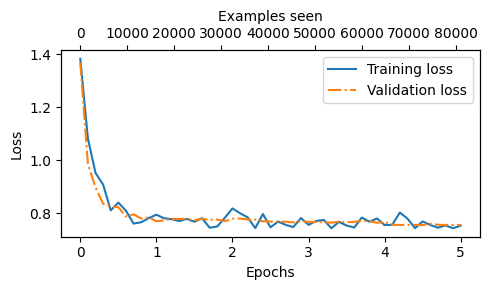

In [42]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(
    epochs_tensor, examples_seen_tensor, train_losses, val_losses, save_plot=False
)

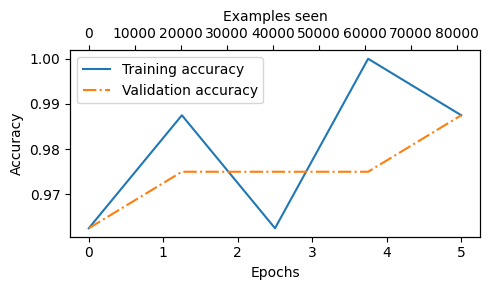

In [43]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor,
    examples_seen_tensor,
    train_accs,
    val_accs,
    label="accuracy",
    save_plot=False,
)

In [44]:
train_accuracy: float = calc_accuracy_loader(train_loader, model, device)
val_accuracy: float = calc_accuracy_loader(val_loader, model, device)
test_accuracy: float = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.49%
Validation accuracy: 98.17%
Test accuracy: 97.95%


In [144]:
def classify_transaction(
    text: str, model: nn.Module, transformation: Any, device: str | torch.device
) -> dict[str, Any]:
    model.eval()

    labels: list[str] = ["bills", "loan", "savingsAndInvestments", "noSpend"]
    cleaned_text: str = (
        DataCleaner(data=pl.DataFrame(data={"text": text}))
        .prepare_data()
        .select(["cleaned_text"])
        .to_series()
        .to_list()[0]
    )

    encoded_input: BatchEncoding = transformation(cleaned_text)
    # Move each element of input_batch to the device
    enc_input: dict[str, Any] = {
        key: value.to(device) for key, value in encoded_input.items()
    }

    with torch.no_grad():
        logits: torch.Tensor = model(enc_input)
    probas: Tensor = F.softmax(logits, dim=-1).squeeze(0)

    spend_labels: list[tuple[str, int]] = [
        (label, round(proba.item(), 2)) for label, proba in zip(labels, probas)
    ]
    # Sort using the proba
    spend_labels = sorted(spend_labels, key=lambda x: x[1], reverse=True)
    sorted_spend_labels: list[dict[str, float]] = [
        {label: proba} for label, proba in spend_labels
    ]

    return {"transaction": text, "spend_labels": sorted_spend_labels}

### Save And Load Model


```python
# Save
torch.save(model.state_dict(), "model_name.pth")


# Load
model_state_dict = torch.load("model_name.pth")
model.load_state_dict(model_state_dict)
```

In [46]:
# Save model
# torch.save(model.state_dict(), "models/hf_spend_classifier.pth")

# Load Model
model_state_dict = torch.load("models/hf_spend_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [145]:
# Bills
text_1: str = "Payment of Bolt Fare to Philip"

console.print(classify_transaction(text_1, model, transformation, device))

{
    'transaction': 'Payment of Bolt Fare to Philip',
    'spend_labels': [{'bills': 0.47}, {'loan': 0.18}, {'savingsAndInvestments': 0.18}, {'noSpend': 0.18}]
}

In [146]:
# Savings
text_1: str = "TRF/Monthly contribution /FRM JOSEPH DOE TO MIKE"

console.print(classify_transaction(text_1, model, transformation, device))

{
    'transaction': 'TRF/Monthly contribution /FRM JOSEPH DOE TO MIKE',
    'spend_labels': [{'savingsAndInvestments': 0.47}, {'bills': 0.18}, {'loan': 0.18}, {'noSpend': 0.18}]
}

In [147]:
# Loan
text_1: str = "REV-MONNIFY / FairMoney-Jane Doe- 022"

console.print(classify_transaction(text_1, model, transformation, device))

{
    'transaction': 'REV-MONNIFY / FairMoney-Jane Doe- 022',
    'spend_labels': [{'loan': 0.48}, {'bills': 0.17}, {'savingsAndInvestments': 0.17}, {'noSpend': 0.17}]
}

In [148]:
# NoSpend
text_1: str = "Trf from Neidu to Femi"

console.print(classify_transaction(text_1, model, transformation, device))

{
    'transaction': 'Trf from Neidu to Femi',
    'spend_labels': [{'noSpend': 0.48}, {'bills': 0.17}, {'loan': 0.17}, {'savingsAndInvestments': 0.17}]
}

In [154]:
text_1: str = "a a rano nig"

console.print(classify_transaction(text_1, model, transformation, device))

{
    'transaction': 'a a rano nig',
    'spend_labels': [{'noSpend': 0.48}, {'bills': 0.17}, {'loan': 0.17}, {'savingsAndInvestments': 0.17}]
}

In [52]:
df.filter(pl.col("label").str.contains("loan")).sample(n=20).to_pandas()

,customer_id,nuban,description,label,cleaned_text,desc_length
0,35295,1,Principal Liquidation 099ILAT2222305WW 220811001238AF54,loan,principal liquidation ilatww af,31
1,35641,1,POS/WEB PMT PALMCREDIT/1879176020 PSTK LANG,loan,pos web pmt palmcredit pstk lang,33
2,35542,1,Main Interest Liquidation 099ILAT21330000N 211126054644CD14,loan,main interest liquidation ilatn cd,34
3,34100,1,Main Interest Liquidation 099ILAT2223706QY 2208252054344587,loan,main interest liquidation ilatqy,33
4,34197,1,Principal Liquidation 099ILAT222620076 2209190807442EB9,loan,principal liquidation ilat eb,29
5,34981,1,TRF//FRM OGUNGBE ABAYOMI SAMUEL TO / FairMoney-Aba MONNIFY - 232,loan,trf frm ogungbe abayomi samuel fairmoney aba monnify,53
6,34544,1,Principal Liquidation 099ILAT2219700CA 2207161204274A0E,loan,principal liquidation ilatca ae,31
7,34726,1,CASHIGO INTERNATIONAL LIMITED- 057,loan,cashigo international limited,30
8,35559,1,Main Interest Liquidation 099ILAT2225100IS 22090814054198C5,loan,main interest liquidation ilatis c,34
9,35675,1,Principal Liquidation 099ILAT21329047Q 211125122144CFF8,loan,principal liquidation ilatq cff,31


In [69]:
fp: str = "../data_prep/trans_TAGS_4.parquet"
unseen_data: pl.DataFrame = (
    pl.read_parquet(fp)
    .filter(pl.col("type").str.contains("D"))
    .drop(["nuban", "date", "type", "amount"])
)
print(f"Shape of data: {unseen_data.shape[0]:,} \n")
unseen_data = unseen_data.with_columns(
    tags=pl.col("tags").map_elements(lambda x: ", ".join(x))
)
unseen_data.head().to_pandas()

Shape of data: 1,742,257 



,customer_id,description,tags
0,8549,FGN ELECTRONIC MONEY TRANSFER LEVY,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.spendOnTransfers, cashflow.firstDay, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
1,8549,Quantum USSD,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.ussdTransactions, cashflow.firstDay, transactionpattern.transactionBetween10000And100000, transactionpattern.mostFrequentBalanceRange"
2,8549,Quantum USSD,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.ussdTransactions, cashflow.firstDay, transactionpattern.transactionBetween10000And100000, transactionpattern.mostFrequentBalanceRange"
3,8549,Quantum USSD,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.ussdTransactions, cashflow.firstDay, transactionpattern.transactionBetween10000And100000, transactionpattern.mostFrequentBalanceRange"
4,8549,Quantum USSD,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.ussdTransactions, cashflow.firstDay, transactionpattern.transactionBetween10000And100000, transactionpattern.mostFrequentBalanceRange"


In [118]:
unseen_data.filter(pl.col("tags").str.contains("savings")).sample(n=20).to_pandas()

,customer_id,description,tags
0,7669,POS/WEB PMT PIGGYVEST/1679560504 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.recurringExpense, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
1,7546,POS/WEB PMT PIGGYVEST/1945072675 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.recurringExpense, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
2,8619,POS/WEB PMT PIGGYVEST/2365489167 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
3,8096,POS/WEB PMT PIGGYVEST/2059320772 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.recurringExpense, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
4,8166,TRF/Thanks/FRM OLUNIYI ADEYEMI OLUGBILE TO PIGGYVEST/ENIOLAKOLADE PRAISE- 035,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.savingsAndInvestments, spend.spendOnTransfers, transactionpattern.transactionBetween10000And100000, transactionpattern.mostFrequentBalanceRange"
5,8248,POS/WEB PMT PIGGYVEST/1767570624 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
6,8215,POS/WEB PMT PIGGYVEST/1636361639 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
7,8096,POS/WEB PMT PIGGYVEST/1935167297 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
8,8610,POS/WEB PMT PIGGYVEST/1791820837 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.recurringExpense, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"
9,8096,POS/WEB PMT PIGGYVEST/2116189151 PSTK LANG,"balance, behavioural.accountSweep, behavioural.inflowOutflowRate, debit, spend.posSpend, spend.savingsAndInvestments, spend.webSpend, transactionpattern.recurringExpense, transactionpattern.transactionLessThan10000, transactionpattern.mostFrequentTransactionRange, transactionpattern.mostFrequentBalanceRange"


In [152]:
fp: str = "../data_prep/staging_db.parquet"
unseen_data_2: pl.DataFrame = (
    pl.read_parquet(fp)
    .filter(pl.col("type").str.contains("D"))
    .drop(
        [
            "date",
            "type",
            "balance",
            # "amount",
            "created_at",
            "updated_at",
            "analysis_id",
        ]
    )
)
# unseen_data_2.head().to_pandas()

unseen_data_2.filter(
    ((pl.col("tags").str.contains("bills")) & (pl.col("amount").ge(15_000)))
).sample(n=20).to_pandas()

,id,amount,description,tags
0,cfb88397-e54b-11ee-8a77-025b06f85973,70000.00,TRANSFER BETWEEN CUSTOMERS via Internet Banking Lexus GX460 Rental-23/09/2022 from BABAOYE OLASUBOMI THADDEUS to KINGZ AUTOS RENTAL SERVICES,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""spend.spendOnTransfers"", ""transactionpattern.transactionBetween10000And100000""]"
1,2b6305d7-0d0c-11ef-8a77-025b06f85973,50000.00,TRANSFER BETWEEN CUSTOMERS Via USSD GTBank Transfer 00000000201018045621509143070000 50000202208231225/21.5/6.98 from BABAOYE OLASUBOMI THADDEUS to KINGZ AUTOS RENTAL SERVICES,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""spend.spendOnTransfers"", ""spend.ussdTransactions"", ""transactionpattern.recurringExpense"", ""transactionpattern.transactionBetween10000And100000"", ""transactionpattern.mostFrequentBalanceRange""]"
2,afe19ced-d094-11ee-8a77-025b06f85973,126962.66,RESTRUCTURE FEES,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""transactionpattern.transactionBetween100000And500000""]"
3,32307b42-e125-11ee-8a77-025b06f85973,89574.68,MANAGEMENT FEES,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bankCharges"", ""spend.bills"", ""transactionpattern.transactionBetween10000And100000""]"
4,753f1aaa-d643-11ee-8a77-025b06f85973,114592.08,total ss,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""transactionpattern.transactionBetween100000And500000"", ""transactionpattern.mostFrequentBalanceRange""]"
5,227824ac-d62c-11ee-8a77-025b06f85973,15000.00,petroleum,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""transactionpattern.transactionBetween10000And100000"", ""transactionpattern.mostFrequentBalanceRange""]"
6,86b914fa-1918-11ef-8a77-025b06f85973,50000.00,TRANSFER BETWEEN CUSTOMERS Via USSD GTBank Transfer 00000000201018045621509143070000 50000202208231225/21.5/6.98 from BABAOYE OLASUBOMI THADDEUS to KINGZ AUTOS RENTAL SERVICES,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""spend.spendOnTransfers"", ""spend.ussdTransactions"", ""transactionpattern.recurringExpense"", ""transactionpattern.transactionBetween10000And100000"", ""transactionpattern.mostFrequentBalanceRange""]"
7,73e0dc4a-06e4-11ef-8a77-025b06f85973,126962.66,RESTRUCTURE FEES,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""transactionpattern.transactionBetween100000And500000""]"
8,eeaa102c-d701-11ee-8a77-025b06f85973,20000.00,a a rano nig,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""transactionpattern.transactionBetween10000And100000"", ""transactionpattern.mostFrequentBalanceRange""]"
9,753ee919-d643-11ee-8a77-025b06f85973,17000.00,fenchurch,"[""balance"", ""behavioural.accountSweep"", ""behavioural.inflowOutflowRate"", ""debit"", ""spend.bills"", ""transactionpattern.transactionBetween10000And100000"", ""transactionpattern.mostFrequentBalanceRange""]"
